# Build a language model based on wikipedia in you language 

The notebooke includes the whole process but you will need to help the process if the following problem happens:  
-you internet connection is interrupted (stage 1)

-you run out of diskspace

-because of the huge memory consumption. creatig the databunch for the training requires lots of memory


In order ot handle these problemn the notebook is divided into stages. If the process is failes in a stage then you can resume the processing from the beginning of that stage by:
-restarting the kernel "Kernel"/Restart & Clear Output

-running the cells in stage 0: initialization

-running the cells from the start of the stage that failed 

# Stage 0: Initialisation
lang: You must set the parameter "lang" to the language you want to build a model for. Fx:

fr: for french

en: for english

de:for german

da: for danish 

etc.

pathData: You must se the location where you want your data stored using the parameter pathData. Consider using a ssd-rive

In [1]:
lang="en"

In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
from fastai.text import * 

from IPython.display import display, HTML
from pathlib import *
import re
import shutil

In [4]:
#pathData       = Path("../../data/nlp")
pathData       = Path("../nlp-data")
path           = pathData / lang
pathDump       = path/"wiki-dump"
pathJson       = path/"wiki-json"

pathTrainValid = path/"wiki-train_valid"
pathTxt        = pathTrainValid/"txt"
pathToks       = pathTrainValid/"toks"
pathcsv        = pathTrainValid/"wiki.csv"

cache_name   = "sp-model"
pathVocab    = pathTrainValid / cache_name

# requried libraries: 
conda install -c anaconda psutil 

conda install -c anaconda git 

#conda install -c menpo wget 
conda install curl


# Stage 1: download the selected language from wikipedia and convert the articles to json

In [5]:
if len(list(pathDump.glob("*.bz2")))==0:
    pathDump.mkdir(parents=True,exist_ok=True)
    #fn  = f"{lang}wiki-latest-pages-articles.xml.bz2"
    fn  = f"{lang}wiki-latest-pages-articles-multistream.xml.bz2"
    url = f"https://dumps.wikimedia.org/{lang}wiki/latest/{fn}"
    #cmd = f"wget -c --no-check-certificate --show-progress {str(url)} -P {str(pathDump)}"
    cmd = f'curl -k -C - -o "{str(pathDump/fn)}" "{str(url)}"'
    print(f"If the command fails in the notebook then copy the command and run it in the terminal:{cmd}")
    ! $cmd

# Stage 2: Convert wikipedia dump to articles in json

In [6]:
pathWikiExtractor = Path("../wikiextractor")

In [7]:
if not pathJson.exists():
    !git clone https://github.com/attardi/wikiextractor.git $pathWikiExtractor
    cmd = f"cd {str(pathWikiExtractor)} && python setup.py install"
    ! $cmd

In [8]:
%%time
if not pathJson.exists():
    #extracting the json-files. This takes about 1 hour for french with files read from and saved to a ssd hardrive 
    fn_wikidump = list(pathDump.iterdir())[0]
    cmd = f"cd {str(pathWikiExtractor)} && python WikiExtractor.py -o {str(pathJson)} --json --processes {defaults.cpus} -q  {str(fn_wikidump)}"
    print(f"If WikiExtractor fails in the notebook then copy the command and run it in the terminal:{cmd}")
    ! $cmd

CPU times: user 23 µs, sys: 26 µs, total: 49 µs
Wall time: 56 µs


# Stage 3: building a vocabulary using sentencepiece

Now we separate the title of the wikipedia section from text section that we keep. 

In order to makes a first reduction on the number of section we clean the text with the preprocessing rules from fastai and ignore text with less than "minWords"

You must set the lenght of the shortes sections you want to keep using the parameter "minWords"

In [9]:
minWords  = 10
chunksize = 25000

In [10]:
!pip install sentencepiece

In [11]:
from fastai_sentencepiece import *
from filetokenizer import *

In [12]:
if not pathTxt.exists():
    swm = SentencepieceWikiModel(lang=lang, pathJson=pathJson, pathcsv=pathcsv, pathTxt=pathTxt, pathVocab=pathVocab, minWords=minWords )    
    %time swm.wikijson2TrainingData()   

In [13]:
if not (pathVocab/"m.model").exists():
    swm = SentencepieceWikiModel(lang=lang, pathJson=pathJson, pathcsv=pathcsv, pathTxt=pathTxt, pathVocab=pathVocab, minWords=minWords)
    %time swm.trainVocabulary()

In [14]:
if not (pathVocab/"itos.pkl").exists():
    swm = SentencepieceWikiModel(lang=lang, pathJson=pathJson, pathcsv=pathcsv, pathTxt=pathTxt, pathVocab=pathVocab, minWords=minWords)
    swm.convertVocab()

# Show some examples using the vocabulary

In [15]:
swm = SentencepieceWikiModel(lang=lang, pathJson=pathJson, pathcsv=pathcsv, pathTxt=pathTxt, pathVocab=pathVocab, minWords=minWords)
sp  = spm.SentencePieceProcessor()
sp.Load(str(pathVocab / "m.model"))
print("\nSize of vocabulary:",sp.GetPieceSize())

control_symbols = ["<unk>","xxbos","xxeos","xxpad"]
print(f"Control symbol:")
for s in control_symbols: print(f"{s}({sp.PieceToId(s)})")

print(f"\nUser defined symbols:")
for s in swm.getUserdefinedSymbols():print(f"{s}({sp.PieceToId(s)})")

sentence = "She is tall. He is small"
print(f"Sentence:          {sentence}")
print(f"Sentence as pieces:{sp.EncodeAsPieces(sentence)}")
print(f"Sentence as ids:   {sp.EncodeAsIds(sentence)}")


Size of vocabulary: 32000
Control symbol:
<unk>(0)
xxbos(1)
xxeos(0)
xxpad(2)

User defined symbols:
xxfld(7)
xxmaj(3)
xxup(4)
xxrep(5)
xxwrep(6)
Sentence:          She is tall. He is small
Sentence as pieces:['▁She', '▁is', '▁tall', '.', '▁He', '▁is', '▁small']
Sentence as ids:   [130, 20, 3921, 10, 44, 20, 324]


# Prepare training of the language model

# LM Training
Set the minimum number of tokens for the sections that we shall retain

In [16]:
#Discard section with kess than "minTok" tokens
minToks = 10

In [17]:
spt_func  = partial(SentencepieceTokenizer.create, pathVocab=pathVocab)
spt_func.__name__ = SentencepieceTokenizer.__name__
spt       = spt_func(lang="en")

pad_idx   = spt.vocab().numericalize([text.transform.PAD])[0]
print(f"pad_idx:{pad_idx}")
vocab,max_vocab = spt.vocab(), len(spt.vocab().itos)
trainTokenizer = FileTokenizer(pathToks/"train", spt_func,"en",vocab,minToks=minToks,n_cpus=max(defaults.cpus-1,1))
validTokenizer = FileTokenizer(pathToks/"valid", spt_func,"en",vocab,minToks=minToks,n_cpus=max(defaults.cpus-1,1))


pad_idx:2


In [18]:
files   = np.asarray( list(pathTxt.glob("*.txt")) )
nrows   = len(files)
split   = 0.2
splitindex, index = int(nrows*split+.5), np.random.permutation(np.arange(nrows)) 

chunksize=0

trainList = TextList( files[:-splitindex], vocab=vocab, pad_idx=pad_idx, 
                      processor=[FileTokenizeProcessor(tokenizer=trainTokenizer, 
                                                       chunksize=chunksize, mark_fields=False)])

validList = TextList( files[-splitindex:], vocab=vocab, pad_idx=pad_idx, 
                      processor=[FileTokenizeProcessor(tokenizer=validTokenizer, 
                                                       chunksize=chunksize, mark_fields=False)])


In [19]:
if not (pathToks/"train").exists():
    %time trainList.process()
    trainList=None
    gc.collect()    

In [20]:
if not (pathToks/"valid").exists():
    %time p = validList.process()
    validList=None
    gc.collect()

In [21]:
%time trainIDS = trainTokenizer.getIds()
gc.collect()

CPU times: user 1min 52s, sys: 8.24 s, total: 2min
Wall time: 2min 1s


7

In [22]:
%time validIDS=validTokenizer.getIds()
gc.collect()

CPU times: user 34.8 s, sys: 4.43 s, total: 39.2 s
Wall time: 39.9 s


0

Traning:    number of arrays:24871686 - number of ids:2044746556
Validation: number of arrays:8310438 - number of ids:732773770
Lenght of token rags min:5 max:12985 - median:65.0
rags > 1000 tokes:942
CPU times: user 17.5 s, sys: 7.4 s, total: 24.9 s
Wall time: 23.3 s


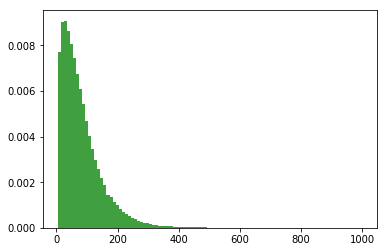

In [23]:
%%time
print(f"Traning:    number of arrays:{len(trainIDS)} - number of ids:{np.sum([len(ids) for ids in trainIDS])}")
print(f"Validation: number of arrays:{len(validIDS)} - number of ids:{np.sum([len(ids) for ids in validIDS])}")

#Analyse the distribution of the legnth of tokens sequences in the ragged/jagged array of tokes
sectionlengths = np.asarray([len(s) for s in trainIDS],dtype=np.int64)
plt.hist(sectionlengths[sectionlengths<1000], 100, density=True, facecolor='g', alpha=0.75)
np.histogram(sectionlengths[sectionlengths<1000],50)

print(f"Lenght of token rags min:{min(sectionlengths)} max:{np.max(sectionlengths)} - median:{np.median(sectionlengths)}")
print(f"rags > 1000 tokes:{np.sum(sectionlengths>1000)}")
gc.collect()

In [24]:
percent     = np.asarray([ 25,50,75,90,97,99,100]) # %np.arange(101,dtype=np.int)
percentiles = np.percentile(sectionlengths,percent).astype(np.int)
print("%  percentile")
for i in range(len(percent)):print(f"{percent[i]}  {percentiles[i]}")
gc.collect()

%  percentile
25  34
50  65
75  111
90  168
97  244
99  319
100  12985


7407

In [52]:
#from languagemodelloader import *

#nTrainToks, nValidToks = int(5e5),int(2e5)
#nTrainToks, nValidToks = int(5e4),int(1e4)
nTrainToks, nValidToks = int(5e3),int(1e3)
nTrainToks, nValidToks=0,0
if nTrainToks>0 and nValidToks>0:
    trainIDS_ = trainIDS[0:nTrainToks]
    validIDS_ = validIDS[0:nValidToks]
    lengths   = sectionlengths[0:nTrainToks]
else:
    trainIDS_ = trainIDS
    validIDS_ = validIDS
    lengths   = sectionlengths

#%time dblm = TextLMDataBunch.from_ids( pathTrainValid, vocab, trainIDS_, validIDS_, bptt=70, bs=64, num_workers=0, lengths=lengths)
#%time dblm = TextLMDataBunch.from_ids( pathTrainValid, vocab, trainIDS_, validIDS_, bptt=70, bs=64, num_workers=0)
#nTrainToks, nValidToks

In [57]:
totalToks=0
def l1(lengths): 
    totalToks=0
    for l in lengths: totalToks += l
    return totalToks
def l2(items): 
    totalToks=0
    for rag in items: totalToks += len(rag)
    return totalToks    
print(f"number of rags:{len(trainIDS_)}")
%timeit l1(lengths)
%timeit l2(trainIDS_)

number of rags:24871686
2.45 s ± 55.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
3.94 s ± 27.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [45]:
dblm.show_batch()

idx,text
0,"▁laws ▁passed ▁by ▁the ▁parliament ▁in ▁17 74 , ▁the ▁in to ler able ▁act s , ▁after ▁the ▁political ▁protest ▁against ▁tea ▁act ▁in , ▁the ▁colony ▁of ▁bay , ▁commonly ▁known ▁as ▁tea ▁party . ▁row an ▁county ▁was ▁the ▁first ▁county ▁in ▁north ▁to ▁adopt ▁such ▁resolution s ▁in ▁the ▁early ▁stages ▁of ▁revolution . ▁the ▁document ▁was ▁discovered ▁in xxup"
1,"▁ tru sse s ▁in xxup ▁of ▁the ▁105 ▁built , ▁and ▁82 ▁timber ▁ tru s s ▁road ▁bridges ▁survive ▁from ▁the ▁over ▁400 ▁built . ▁the xxup ▁v acy ▁bridge ▁is ▁a ▁representative ▁example ▁of ▁timber ▁ tru s s ▁road ▁bridges , ▁and ▁is ▁assessed ▁as ▁being ▁state ▁significant , ▁primarily ▁on ▁the ▁basis ▁of ▁its ▁technical ▁and ▁historical ▁significance . xxup ▁v acy ▁bridge"
2,"▁the ▁2016 ▁success ▁tam ara . xxup ▁v elle ia ▁rose a ▁( pin k ▁v elle ia ) ▁is ▁a ▁member ▁of ▁the ▁good eni aceae ▁family ▁that ▁is ▁native ▁to ▁western ▁and ▁flowers ▁from ▁to . ▁"" v . ▁rose a "" ▁is ▁an ▁annual ▁her b , ▁with ▁flat ▁leaves ▁long ▁and ▁wide , ▁having ▁tooth ed ▁or ▁lobe d ▁margin s . ▁its"
3,"▁a ▁collection ▁of ▁translation ▁of ▁short ▁stories ▁from ▁and ▁abroad . ▁he ▁adapted esh ▁el ku nch war ’ s ▁play ▁"" v ada ▁chi re band i "" ▁in i ▁as ▁"" t ira de ▁fu ti pal "". ▁he ▁has ▁edited ▁"" xxmaj gu jar ati li ka cha yan "" ▁(1997) ▁published ▁by i ity a ▁parish ad . ▁he"
4,"▁an al ▁fin s ▁combined . ▁they ▁are ▁mostly ▁found ▁in ▁temperate ▁to ▁tropical ▁sea s , ▁from ▁reef s ▁to ▁the ▁be n th ope lag ic ▁zone , ▁but ▁some ▁species ▁from ▁the ▁north ▁ocean ▁occur ▁in ▁into ▁waters . ▁the ▁following ▁genera ▁are ▁included ▁in ▁the ▁subfamily ▁by th in inae : xxup ▁a xxup - rib os yl trans fer ase ▁5 ▁is"


In [46]:
%time learn = language_model_learner(dblm, drop_mult=0.2, qrnn=False, pad_token=pad_idx,  callback_fns=ShowGraph )

CPU times: user 422 ms, sys: 99.6 ms, total: 522 ms
Wall time: 521 ms


In [47]:
gc.collect()

3027

epoch,train_loss,valid_loss,accuracy
1,7.422929,7.012081,0.049713


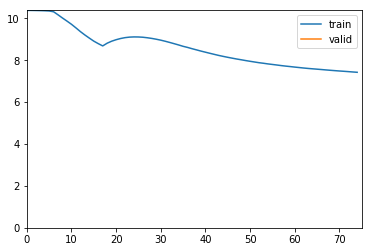

CPU times: user 44min 47s, sys: 2min 18s, total: 47min 5s
Wall time: 13min 43s


In [48]:
#%load_ext line_profiler
%time learn.fit_one_cycle(1,3e-3, moms=(0.8,0.7))